## Measurement platforms in Africa

In [26]:
import requests
import json
from pandas.io.json import json_normalize 
import time
from datetime import date
import pandas as pd
import _thread
import matplotlib.pyplot as plt
import matplotlib.dates
from datetime import datetime
import numpy as np

%matplotlib inline

#set ggplot style
plt.style.use('default')


ATLAS_PROBES_URI = "https://stat.ripe.net/data/atlas-probes/data.json?resource="
ATLAS_DEPLOYMENT_URI = "https://stat.ripe.net/data/atlas-probe-deployment/data.json?resource="

ccs = [
'EG', 'BJ', 'CI', 'CV', 'GH', 'GM', 'GN', 'GW', 'AO', 'CF', 'CG', 'CM', 'GA', 'GQ', 'TD', 'BI', 'DJ', 'ER', 'ET', 'KM', 'BW', 'MA', 'SD', 'TN', 'LR', 'ML', 'MR', 'NE', 'NG', 'SL', 'SN', 'TG', 'ST', 'KE', 'MG', 'MU', 'MW', 'MZ', 'RE', 'RW', 'SC', 'SO', 'UG', 'LS', 'NA', 'SZ', 'ZA', 'DZ', 'EH', 'LY', 'BF', 'SH', 'CD', 'TZ', 'YT', 'ZM', 'ZW']

### RIPE Atlas
We want to understand the evolution of the deployment of RIPE Atlas probes in Africa over the years.

In [ ]:
def getDeployment(cc):
    
    test_url = ATLAS_DEPLOYMENT_URI + cc
    
    df = pd.DataFrame()
    
    try:
        r = requests.get(test_url)
    except requests.exceptions.RequestException as e:
        return "Request FAILED"
    
    try:
        data = json.loads(r.text)['data']['deployments'][0]['deployment']
        df = json_normalize(data)
        df['cc'] = cc
    except KeyError as e:
        pass
    
    return df


# f= open('data/africa_probes_deployment.csv', 'a')
    
# for cc in ccs:
#     print(cc)
#     df = getDeployment(cc)
#     df.to_csv(f, header=False)

# f.close()

In [ ]:
def getProbes(cc):
    
    test_url = ATLAS_PROBES_URI + cc
    
    df = pd.DataFrame()
    
    try:
        r = requests.get(test_url)
    except requests.exceptions.RequestException as e:
        return "Request FAILED"
    
    try:
        data = json.loads(r.text)['data']['probes']
        df = json_normalize(data)
        df['cc'] = cc
    except KeyError as e:
        pass
    
    return df

# f= open('data/africa_probes.csv', 'a')

# for cc in ccs:
#     print(cc)
#     df = getProbes(cc)
#     try:
#         df = df['asn_v4'].astype('int')
#         df = df['asn_v6'].astype('int')
#     except ValueError as e:
#         pass
#     except KeyError as e:
#         pass
    
#     df.to_csv(f, header=False)

# f.close()

In [216]:
# #getProbes('MU').to_csv('data/mu.csv', header=True)
# df1 = pd.read_csv('data/africa_probes.csv')
# try:
#     df1 = df1['asn_v4'].astype('int64')
#     df1 = df1['asn_v6'].astype('int64')
# except ValueError as e:
#     pass
# except KeyError as e:
#     pass
    
# df1.to_csv('data/africa_probes2.csv', header=True)

In [37]:
df = pd.read_csv('data/africa_probes_deployment.csv')
df = df.iloc[:,[0,1,2,3,4]]
df.head()

,date,abandoned,connected,disconnected,neverseen
0,2019-05-10,9.0,1.0,9.0,0.0
1,2019-05-09,9.0,2.0,8.0,0.0
2,2019-05-08,9.0,2.0,8.0,0.0
3,2019-05-07,9.0,2.0,8.0,0.0
4,2019-05-06,9.0,2.0,8.0,0.0


In [38]:
df_agg = df.groupby(['date'])['neverseen', 'abandoned','connected','disconnected'].sum().reset_index()
df_agg.head()

,date,neverseen,abandoned,connected,disconnected
0,2014-01-01T00:00:00,0.0,0.0,0.0,0.0
1,2014-06-13,0.0,0.0,192.0,0.0
2,2014-06-14,0.0,0.0,176.0,0.0
3,2014-06-15,0.0,0.0,188.0,0.0
4,2014-06-16,0.0,0.0,189.0,0.0


We group the rows by date and sum the statuses before plotting

Let's split and re-merge the dataframes

In [45]:
df_neverseen = df.iloc[:,[0,4]]
df_neverseen.columns = {'date','amount'}
df_neverseen= df_neverseen.assign(type = 'neverseen')

df_abandoned = df.iloc[:,[0,1]]
df_abandoned.columns = {'date','amount'}
df_abandoned = df_abandoned.assign(type = 'abandoned')

df_connected = df.iloc[:,[0,2]]
df_connected.columns = {'date','amount'}
df_connected = df_connected.assign(type = 'connected')

df_disconnected = df.iloc[:,[0,3]]
df_disconnected.columns = {'date','amount'}
df_disconnected = df_disconnected.assign(type = 'disconnected')

df_agg2 = pd.concat([df_neverseen, df_abandoned, df_connected, df_disconnected])
df_agg2.head(10)

,date,amount,type
0,2019-05-10,0.0,neverseen
1,2019-05-09,0.0,neverseen
2,2019-05-08,0.0,neverseen
3,2019-05-07,0.0,neverseen
4,2019-05-06,0.0,neverseen
5,2019-05-05,0.0,neverseen
6,2019-05-04,0.0,neverseen
7,2019-05-03,0.0,neverseen
8,2019-05-02,0.0,neverseen
9,2019-05-01,0.0,neverseen


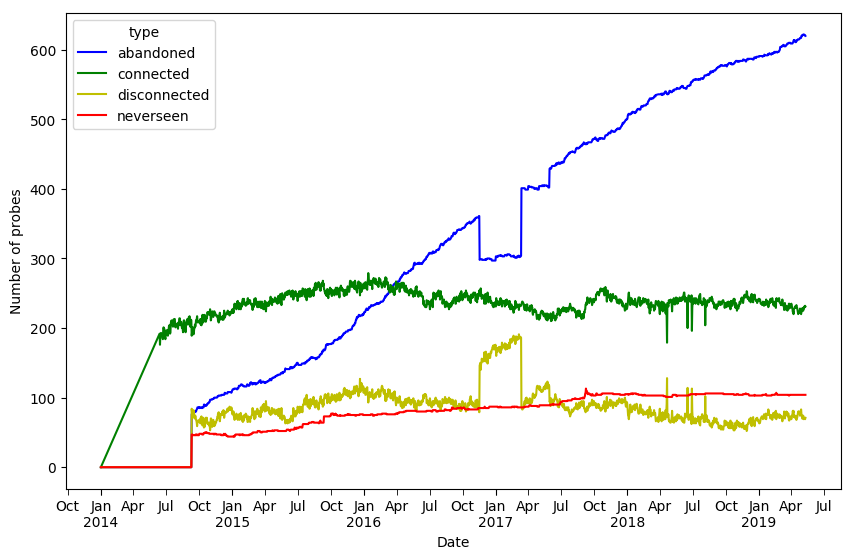

In [46]:
# plot data
fig, ax = plt.subplots(figsize=(10,7))
# use unstack()
df_agg2.date = pd.to_datetime(df_agg2['date'], format='%Y-%m-%d')

styles = ['b','g','y', 'r']

df_agg2.groupby(['date','type']).sum()['amount'].unstack()

df_agg2.groupby(['date','type']).sum()['amount'].unstack().plot(style=styles, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Number of probes')

ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator((1,4,7,10)))

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("\n%Y"))
ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%b"))
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
ax.tick_params(axis="x", which="both", length=4)

plt.savefig("data/plots/probes_deployment_timeseries.pdf")
plt.show()


## Geographic distribution

### Connected probes

In [48]:
import pandas as pd
import plotly.plotly as py

df = pd.read_csv('data/africa_probes.csv')

data = dict(
        type = 'scattergeo',
        locationmode = 'country names', 
        mode = 'markers'
        )

data_connected = data.copy()
data_connected['lon'] = df[df['status'] == 1 ]['longitude']
data_connected['lat'] = df[df['status'] == 1 ]['latitude']
data_connected['marker'] = dict(color = 'green')
data_connected['name'] = 'Connected'

layout = dict(
        #title = 'Probes distribution April 2019',
        showlegend = False,
        geo = dict(
            scope='africa',
            projection=dict( type='country names' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)",
        ),
    )

fig = dict(data=[data_connected], layout=layout)
py.iplot( fig, validate=False, filename='d3-bubble-map-populations')

### Disconnected probes

In [246]:
import pandas as pd
import plotly.plotly as py

df = pd.read_csv('data/africa_probes.csv')

data = dict(
        type = 'scattergeo',
        locationmode = 'country names', 
        mode = 'markers'
        )

data_disconnected = data.copy()
data_disconnected['lon'] = df[df['status']  == 2 ]['longitude']
data_disconnected['lat'] = df[df['status']  == 2 ]['latitude']
data_disconnected['marker'] = dict(color = 'red')
data_disconnected['name'] = 'Disconnected'

layout = dict(
        #title = 'Disconnected Probes',
        showlegend = False,
        geo = dict(
            scope='africa',
            projection=dict( type='country names' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=[data_disconnected], layout=layout)
py.iplot( fig, validate=False, filename='d3-bubble-map-populations' )

### Abandoned probes

In [49]:
import pandas as pd
import plotly.plotly as py

df = pd.read_csv('data/africa_probes.csv')

data = dict(
        type = 'scattergeo',
        locationmode = 'country names', 
        mode = 'markers'
        )

data_abandoned = data.copy()
data_abandoned['lon'] = df[df['status']  == 3 ]['longitude']
data_abandoned['lat'] = df[df['status']  == 3 ]['latitude']
data_abandoned['marker'] = dict(color = 'blue')
data_abandoned['name'] = 'Abandoned'

layout = dict(
        #title = 'Disconnected',
        showlegend = False,
        geo = dict(
            scope='africa',
            projection=dict( type='country names' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=[data_abandoned], layout=layout)
py.iplot( fig, validate=False, filename='d3-bubble-map-populations' )

In [248]:
import pandas as pd
import plotly.plotly as py

df = pd.read_csv('data/africa_probes.csv')

data = dict(
        type = 'scattergeo',
        locationmode = 'country names', 
        mode = 'markers'
        )

data_neverseen = data.copy()
data_neverseen['lon'] = df[df['status']  == 0 ]['longitude']
data_neverseen['lat'] = df[df['status']  == 0 ]['latitude']
data_neverseen['marker'] = dict(color = 'black')
data_neverseen['name'] = 'Never seen'

layout = dict(
        #title = 'Never seen',
        showlegend = False,
        geo = dict(
            scope='africa',
            projection=dict( type='country names' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=[data_neverseen], layout=layout)
py.iplot( fig, validate=False, filename='d3-bubble-map-populations' )

### Distribution by country

In [50]:
df = pd.read_csv('data/africa_probes.csv')
df = df.iloc[:,[6,15,17,20]]
df_agg = df.groupby(['cc','status_name']).size().reset_index(name='counts')
df = df_agg.pivot(index='cc', columns='status_name',values='counts')
df.to_csv('data/cc_distribution.csv')
df = pd.read_csv('data/cc_distribution.csv')
df.fillna(0, inplace=True)

In [51]:
df['Abandoned_pct'] = df.apply(lambda x: 100*x['Abandoned']/(x['Abandoned']+x['Connected']+x['Disconnected']+x['Never Connected']), axis=1)
df['Connected_pct'] = df.apply(lambda x: 100*x['Connected']/(x['Abandoned']+x['Connected']+x['Disconnected']+x['Never Connected']), axis=1)
df['Disconnected_pct'] = df.apply(lambda x: 100*x['Disconnected']/(x['Abandoned']+x['Connected']+x['Disconnected']+x['Never Connected']), axis=1)
df['Neverseen_pct'] = df.apply(lambda x: 100*x['Never Connected']/(x['Abandoned']+x['Connected']+x['Disconnected']+x['Never Connected']), axis=1)

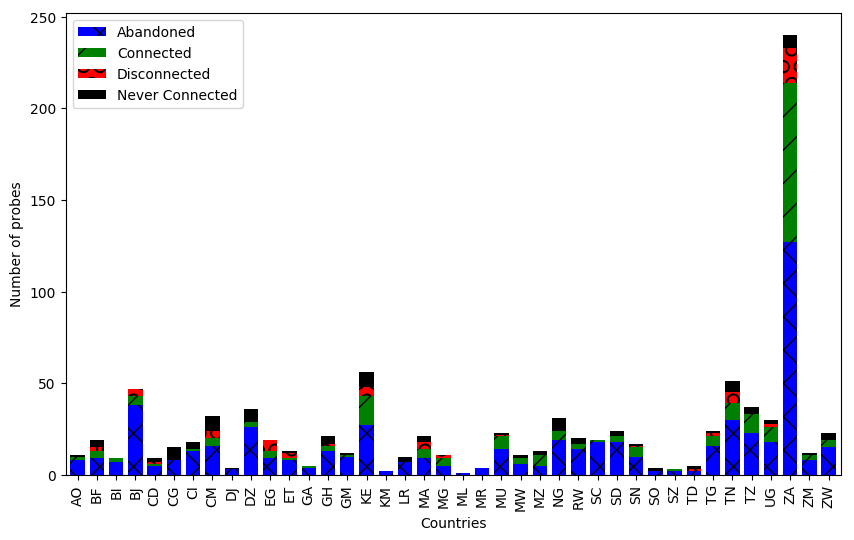

In [52]:
ax = df.plot.bar(x='cc', y=['Abandoned','Connected','Disconnected','Never Connected'], stacked=True, figsize=(10,6), color=('blue', 'green', 'red', 'black'), width=0.75)
plt.ylabel('Number of probes')
plt.xlabel('Countries')

bars = ax.patches
hatches = ''.join(h*len(df) for h in 'x/O.')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
ax.legend(ncol=1)

plt.savefig("data/plots/probes_distribution_by_status_by_cc.pdf", bbox="tight")
plt.show()

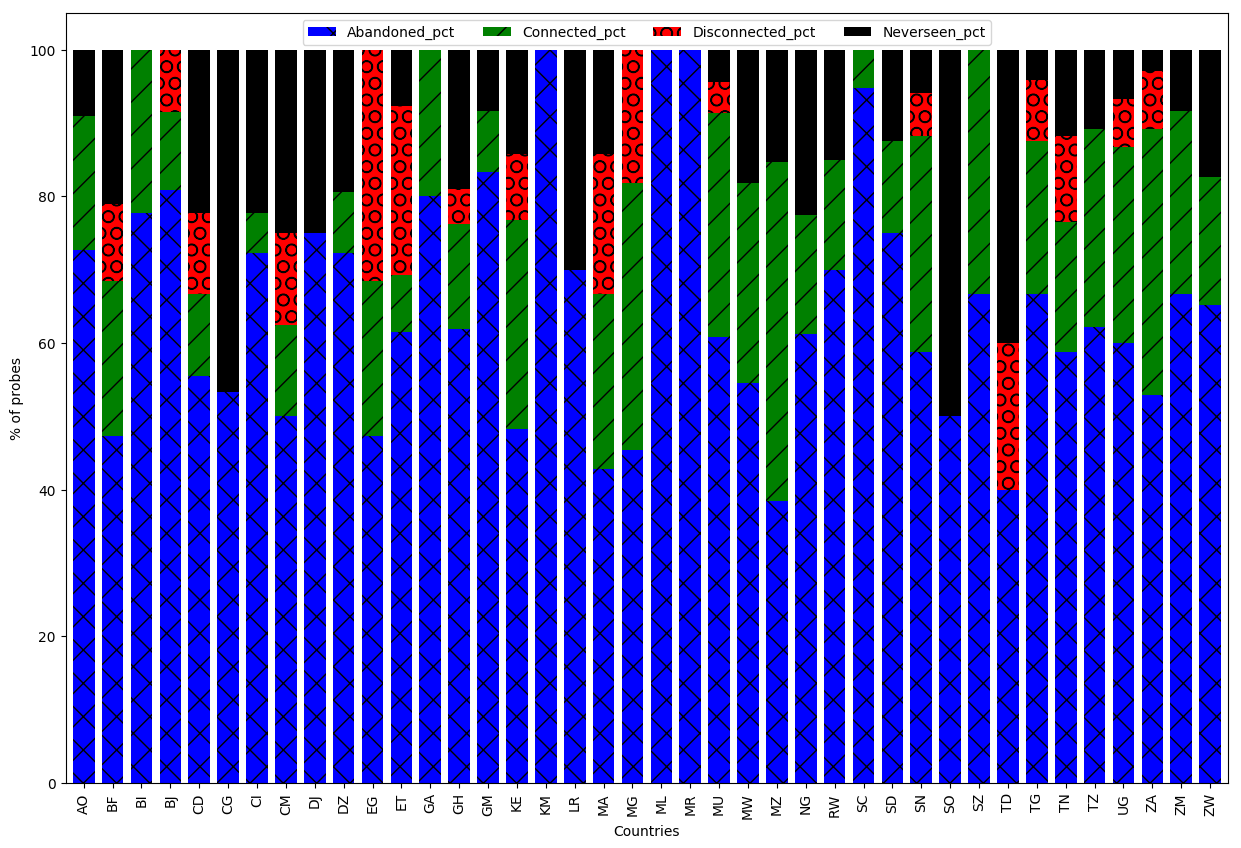

In [53]:
ax = df.plot.bar(x='cc', y=['Abandoned_pct','Connected_pct','Disconnected_pct','Neverseen_pct'], stacked=True, figsize=(15,10), color=('blue', 'green', 'red', 'black'), width=0.75)
plt.ylabel('% of probes')
plt.xlabel('Countries')

bars = ax.patches
hatches = ''.join(h*len(df) for h in 'x/O.')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
ax.legend(loc='upper center', ncol=4)

plt.savefig("data/plots/probes_distribution_by_status_by_cc_percentage.pdf", bbox="tight")
plt.show()

In [54]:
# df1 = pd.DataFrame(columns=['cc','asn_covered','asn_allocated'])

# for cc in df_probes_asn.iloc[:,[20]].drop_duplicates().dropna().cc.values:
#     try:
#         df1.append({'cc':cc, 'asn_covered': getCountASN(cc, df_probes_asn), 'asn_allocated':getTotalAllocated(cc, df_allocated_afrinic)}, ignore_index=True)
#     except KeyError as e:
#         pass
    
# df1

NameError: name 'df_probes_asn' is not defined

## AS Coverage

In [56]:
df_allocated_afrinic = pd.read_csv('http://ftp.afrinic.net/pub/stats/afrinic/delegated-afrinic-extended-latest', sep='|', skiprows=5, names=['rir', 'cc', 'type', 'value', 'flag', 'allocdate', 'status','opaqueid'])
df_allocated_afrinic = df_allocated_afrinic.loc[(df_allocated_afrinic.type=='asn') & (df_allocated_afrinic.status=='allocated')]

In [57]:
df_probes_asn = pd.read_csv('data/africa_probes.csv')

### Global coverage i.e. % of ASNs are covered in Africa

In [58]:
asn_v4 = len(df_probes_asn.loc[(df_probes_asn.status==1)].asn_v4.dropna().unique())
print(asn_v4)
asn_v6 = len(df_probes_asn.loc[df_probes_asn.status==1].asn_v6.dropna().unique())
print(asn_v6)


126
39


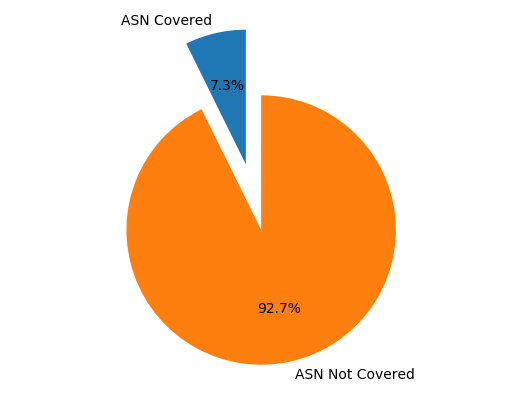

In [59]:
labels = 'ASN Covered', 'ASN Not Covered'
sizes = [126, 1601]
explode = (0, 0.5)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig("data/plots/pie_chart_global_africa_coverage.pdf", bbox="tight")
plt.show()

### ASN Coverage by country

In [60]:
def getTotalAllocated(cc, df):
    return len(df.loc[df.cc==cc].values)

def getCountASN(cc, df):
    return df.iloc[:,[2,4]].dropna().groupby(['country_code']).asn_v4.nunique()[cc]

In [61]:
#Get the set of probes, group by cc and get the number of ASNs

df = df_probes_asn.iloc[:,[2,20]].drop_duplicates().dropna().groupby(['cc']).size().reset_index(name='ASN_covered').sort_values(by=['ASN_covered'], ascending=False)

In [62]:
df['ASN_Allocated'] = df.apply(lambda x: getTotalAllocated(x['cc'], df_allocated_afrinic), axis=1)
df['Percentage'] = df.apply(lambda x: 100*x['ASN_covered']/getTotalAllocated(x['cc'], df_allocated_afrinic), axis=1)

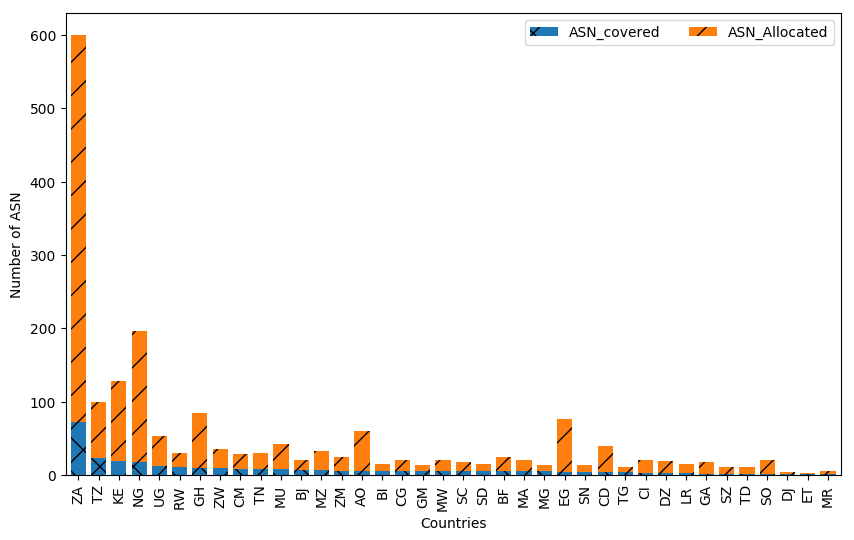

In [63]:
ax = df.plot.bar(x='cc', y=['ASN_covered','ASN_Allocated'], stacked=True, figsize=(10,6), width=0.75)
plt.ylabel('Number of ASN')
plt.xlabel('Countries')
#plt.savefig("../data/plots/percentage_website_local_vs_remote_ordered.pdf", bbox="tight")
bars = ax.patches
hatches = ''.join(h*len(df) for h in 'x/O.')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
ax.legend(bbox_to_anchor=(1, 1), ncol=2)
plt.savefig("data/plots/covered_asn_distribution_by_cc.pdf", bbox="tight")
plt.show()

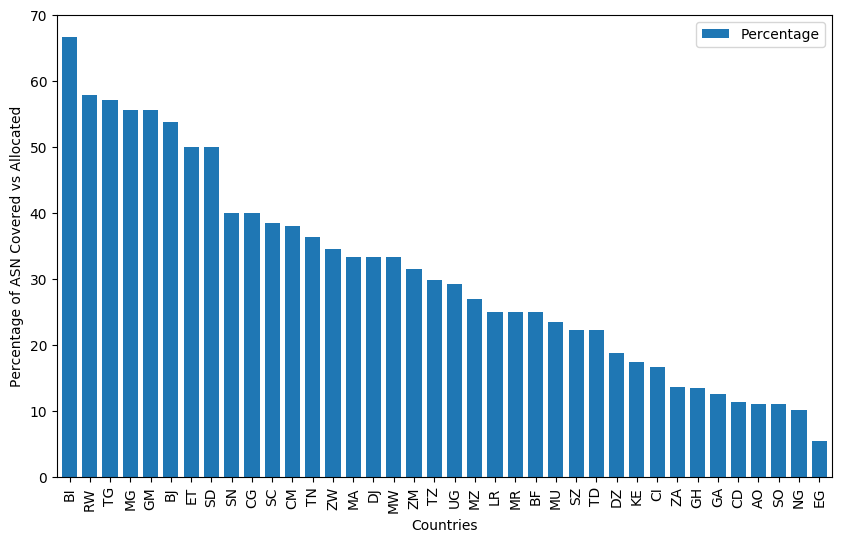

In [64]:
df.sort_values(by=['Percentage'], ascending=False).plot.bar(x='cc', y=['Percentage'], stacked=True, figsize=(10,6), width=0.75)
plt.ylabel('Percentage of ASN Covered vs Allocated')
plt.xlabel('Countries')
plt.savefig("data/plots/percentage_covered_asn_distribution_by_cc.pdf", bbox="tight")
plt.show()

## Eyeball networks
We use data from APNIC and classify ASNs with active probes. We can then see whether the active probes are covering enough eyeballs. 

In [65]:
df_probes = pd.read_csv('data/africa_probes.csv')
df_probes = df_probes.iloc[:,[2, 15]].dropna()
df_probes.asn_v4 = df_probes.asn_v4.astype('int64')
df_probes['asn_v4'] = df_probes.apply(lambda x: 'AS' + str(x['asn_v4']), axis=1)

# df_agg = df_probes.groupby(['asn_v4','status_name']).size().reset_index(name='counts')
# df_probes = df_agg.pivot(index='asn_v4', columns='status_name',values='counts')
# df_probes.to_csv('data/asn_distribution.csv')
# df_probes = pd.read_csv('data/asn_distribution.csv')
# df_probes.fillna(0, inplace=True)
df_probes.head()

,asn_v4,status_name
0,AS36907,Abandoned
1,AS3741,Abandoned
2,AS11259,Abandoned
4,AS37645,Connected
5,AS37468,Connected


In [66]:
df_apnic = pd.read_csv('data/asn_apnic.csv')
df_apnic.head()

,Rank,asn_v4,AS_Name,CC,Users,country_pct,Internet_pct,Samples
0,1,AS4134,"CHINANET-BACKBONE No.31,Jin-rong Street",CN,313840394,42.36,9.0216,10541389
1,2,AS55836,RELIANCEJIO-IN Reliance Jio Infocomm Limited,IN,176773827,37.19,5.0815,24749700
2,3,AS4837,CHINA169-BACKBONE CHINA UNICOM China169 Backbone,CN,119269448,16.10,3.4285,4006067
3,4,AS45609,BHARTI-MOBILITY-AS-AP Bharti Airtel Ltd. AS fo...,IN,65474205,13.77,1.8821,9166894
4,5,AS9808,CMNET-GD Guangdong Mobile Communication Co.Ltd.,CN,53750768,7.25,1.5451,1805401


We merge the two tables and extract ASNs from Africa only (left join)

In [67]:
df_merged = pd.merge(df_probes, df_apnic, on='asn_v4', how='left')
df_merged = df_merged.sort_values(by='Rank', ascending=True)
df_merged.head()

,asn_v4,status_name,Rank,AS_Name,CC,Users,country_pct,Internet_pct,Samples
301,AS7922,Abandoned,6.0,"COMCAST-7922 - Comcast Cable Communications, LLC",US,49214510.0,16.92,1.4147,12399436
423,AS29465,Abandoned,12.0,VCG-AS,NG,27576115.0,29.93,0.7927,503040
436,AS29465,Abandoned,12.0,VCG-AS,NG,27576115.0,29.93,0.7927,503040
438,AS29465,Abandoned,12.0,VCG-AS,NG,27576115.0,29.93,0.7927,503040
323,AS36903,Disconnected,43.0,MT-MPLS,MA,11655421.0,55.36,0.3350,1337415


CDF showing how probes are distributed by status vs ASN Rank (Global)

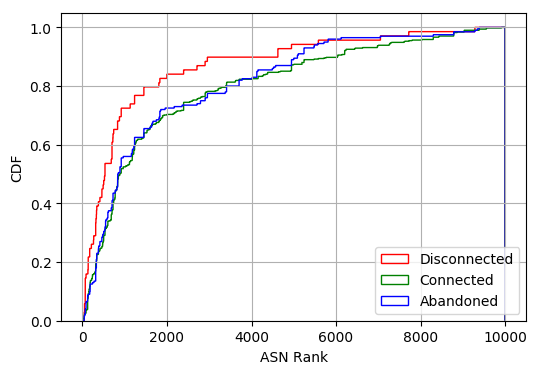

In [68]:
n_bins = 5000

fig, ax1 = plt.subplots(figsize=(6, 4))

labels = ['Abandoned', 'Connected', 'Disconnected']

linestyles = ['solid','dashed']
#plot the cumulative histogram
# n, bins, patches = ax1.hist([df_merged['Abandoned'].values, 
#                             df_merged['Connected'].values, 
#                             df_merged['Disconnected'].values
#                            ], 
#                            n_bins, density=1, histtype='step', linewidth=2, 
#                             #range=[0,10],
#                            cumulative=True, label=labels)

a = np.sort(df_merged.loc[df_merged.status_name=='Connected']['Rank'].dropna())
b = np.sort(df_merged.loc[df_merged.status_name=='Abandoned']['Rank'].dropna())
c = np.sort(df_merged.loc[df_merged.status_name=='Disconnected']['Rank'].dropna())
#y = np.arrange(1, len(x)+1) / len(x)

n, bins, patches = ax1.hist([a,b,c], 
                           n_bins, density=1, histtype='step', linewidth=1, 
                           range=[0,10000],
                           cumulative=True, label=labels, color=['blue','green','red'])



# tidy up the figure
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set_xlabel('ASN Rank')
ax1.set_ylabel('CDF')

from matplotlib.ticker import ScalarFormatter
for axis in [ax1.xaxis, ax1.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.savefig("data/plots/CDF_asnrank_by_status.pdf")
plt.show()

CDF showing how probes are distributed by status vs number of estimated users (APNIC)

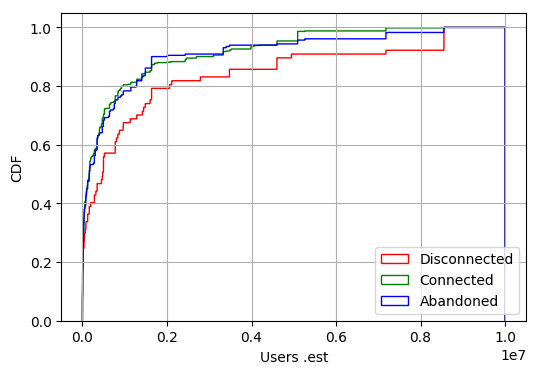

In [69]:
n_bins = 5000

fig, ax1 = plt.subplots(figsize=(6, 4))

labels = ['Abandoned', 'Connected', 'Disconnected']

linestyles = ['solid','dashed']
#plot the cumulative histogram
# n, bins, patches = ax1.hist([df_merged['Abandoned'].values, 
#                             df_merged['Connected'].values, 
#                             df_merged['Disconnected'].values
#                            ], 
#                            n_bins, density=1, histtype='step', linewidth=2, 
#                             #range=[0,10],
#                            cumulative=True, label=labels)

a = np.sort(df_merged.loc[df_merged.status_name=='Connected']['Users'].dropna())
b = np.sort(df_merged.loc[df_merged.status_name=='Abandoned']['Users'].dropna())
c = np.sort(df_merged.loc[df_merged.status_name=='Disconnected']['Users'].dropna())
#y = np.arrange(1, len(x)+1) / len(x)

n, bins, patches = ax1.hist([a,b,c], 
                           n_bins, density=1, histtype='step', linewidth=1, 
                           range=[0,10000000],
                           cumulative=True, label=labels, color=['blue','green','red'])



# tidy up the figure
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set_xlabel('Users .est')
ax1.set_ylabel('CDF')

from matplotlib.ticker import ScalarFormatter
for axis in [ax1.xaxis, ax1.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

plt.savefig("data/plots/CDF_eyeballs_by_status.pdf")
plt.show()

## Analysis by network type

In [16]:
#use peeringDB to get network type
def getNetworkType(asn):
    peeringdb_url = "https://peeringdb.com/api/net?asn=" + str(np.int64(asn))
    
    print(peeringdb_url)
    
    data = 'Unknown'
    
    try:
        r = requests.get(peeringdb_url)
    except requests.exceptions.RequestException as e:
        return "Request FAILED"
    
    try:
        data = json.loads(r.text)['data'][0]['info_type']
    except KeyError as e:
        pass
    except IndexError as e:
        pass
    
    return data

In [17]:
df_probes = pd.read_csv('data/africa_probes.csv')
df_probes = df_probes.iloc[:,[2, 15]].dropna()
df_probes.asn_v4 = df_probes.asn_v4.astype('int64')
#df_probes['asn_v4'] = df_probes.apply(lambda x: 'AS' + str(x['asn_v4']), axis=1)
df_agg = df_probes.groupby(['asn_v4','status_name']).size().reset_index(name='counts')
df_probes = df_agg.pivot(index='asn_v4', columns='status_name',values='counts')
df_probes.to_csv('data/asn_distribution.csv')


df_probes = pd.read_csv('data/asn_distribution.csv')
df_probes.asn_v4 = df_probes.asn_v4.astype('int64')
df_probes.fillna(0, inplace=True)
#df_probes['network_type'] = df_probes.apply(lambda x: getNetworkType(x['asn_v4']), axis=1)
df_probes.to_csv('data/asn_distribution.csv')
df_probes.head()

,asn_v4,Abandoned,Connected,Disconnected
0,766,1.0,0.0,0.0
1,2018,8.0,4.0,0.0
2,2561,1.0,0.0,0.0
3,2609,11.0,2.0,3.0
4,3208,3.0,0.0,0.0


In [18]:
df_networktype = pd.read_csv('data/network_type.csv')
df_probes['network_type'] = df_probes.apply(lambda x: df_networktype.loc[df_networktype.asn_v4==x['asn_v4'],'network_type'].values[0], axis=1)
df_probes.head()

,asn_v4,Abandoned,Connected,Disconnected,network_type
0,766,1.0,0.0,0.0,Educational/Research
1,2018,8.0,4.0,0.0,Educational/Research
2,2561,1.0,0.0,0.0,Unknown
3,2609,11.0,2.0,3.0,NSP
4,3208,3.0,0.0,0.0,Unknown


In [21]:
df_agg = df_probes.iloc[:,[1,2,3,4]].groupby(['network_type'])['Abandoned','Connected','Disconnected'].sum().reset_index()
df_agg['Abandoned_pct'] = df_agg.apply(lambda x: 100*x['Abandoned']/(x['Abandoned']+x['Connected']+x['Disconnected']), axis=1)
df_agg['Connected_pct'] = df_agg.apply(lambda x: 100*x['Connected']/(x['Abandoned']+x['Connected']+x['Disconnected']), axis=1)
df_agg['Disconnected_pct'] = df_agg.apply(lambda x: 100*x['Disconnected']/(x['Abandoned']+x['Connected']+x['Disconnected']), axis=1)
df_agg

,network_type,Abandoned,Connected,Disconnected,Abandoned_pct,Connected_pct,Disconnected_pct
0,Cable/DSL/ISP,165.0,90.0,27.0,58.510638,31.914894,9.574468
1,Content,3.0,4.0,1.0,37.500000,50.000000,12.500000
2,Educational/Research,13.0,9.0,0.0,59.090909,40.909091,0.000000
3,Enterprise,7.0,1.0,0.0,87.500000,12.500000,0.000000
4,NSP,132.0,53.0,18.0,65.024631,26.108374,8.866995
5,Non-Profit,3.0,6.0,0.0,33.333333,66.666667,0.000000
6,Not Disclosed,64.0,20.0,10.0,68.085106,21.276596,10.638298
7,Route Server,5.0,2.0,0.0,71.428571,28.571429,0.000000
8,Unknown,99.0,33.0,8.0,70.714286,23.571429,5.714286


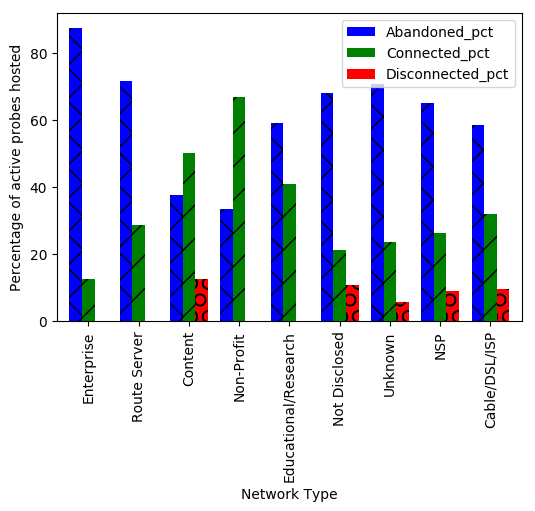

In [28]:
ax = df_agg.sort_values(by='Connected', ascending=True).plot.bar(x='network_type', 
                                                                 y=['Abandoned_pct','Connected_pct','Disconnected_pct'], 
                                                                 stacked=False, figsize=(6,4), color=('blue', 'green', 'red'), rot=90, width=0.75)
plt.ylabel('Percentage of active probes hosted')
plt.xlabel('Network Type')

bars = ax.patches
hatches = ''.join(h*len(df_agg) for h in 'x/O.')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    


plt.savefig("data/plots/probes_distribution_by_networktype_pct.pdf", bbox="tight")
plt.show()

## Analysis by Probe tags